## Intro

In this notebook we introduce some pipeline concepts.

We have to create 3 objects:
- One for RobustScaler transformation.
- Another to re-structure the data.
- And the third, to train the model (or predict)

## LIBRARIES

In [1]:
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error as rmse
from sklearn.metrics import mean_absolute_error as mae

import pipe_needs

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from datetime import datetime

import joblib

2023-03-26 16:47:34.379908: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-26 16:47:35.066902: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/y41000/miniconda3/envs/tensorfl/lib/:/home/y41000/miniconda3/envs/tensorfl/lib/
2023-03-26 16:47:35.067020: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/y41000/miniconda3/envs/tensorfl/lib/

In [2]:
ventana = 120 #10 días
n_features = 1
epochs = 100
corte_fecha = 201212
corte_train_test = 202208
INPUTPATH = '/home/y41000/repos/basic-sklearn-pipeline/'

## DATA GENERAL PRE-PROCESSING

In [3]:
# Read.
data1 = pd.read_csv(INPUTPATH+'data/EURUSD_Candlestick_1_h_ASK_31.12.2011-31.01.2023.csv', usecols = ['Gmt time','Close'])

# Basic transformations.
data1['fecha'] = pd.to_datetime(data1['Gmt time'],format='%d.%m.%Y %H:%M:%S.%f')
data1[f'precio_EURUSD'] = data1['Close']

# Select records from 2013 onwards.
data1 = data1[(data1['fecha'].dt.year*100+data1['fecha'].dt.month)>corte_fecha]

# Temporal order.
data1.sort_values('fecha',inplace=True)

# NULOS
# For the null values we will take the preceed value.
data1['precio_EURUSD'] = data1['precio_EURUSD'].fillna(method='ffill')
# Except when we do not have a preceed value, then we will take the next value.
data1['precio_EURUSD'] = data1['precio_EURUSD'].fillna(method='bfill')

# Target and TRAIN/TEST.
X_train=data1[(data1['fecha'].dt.year*100+data1['fecha'].dt.month)< corte_train_test][['fecha','precio_EURUSD']]
X_test =data1[(data1['fecha'].dt.year*100+data1['fecha'].dt.month)>=corte_train_test][['fecha','precio_EURUSD']]
y_train=data1[(data1['fecha'].dt.year*100+data1['fecha'].dt.month)< corte_train_test][['fecha','precio_EURUSD']].rename(columns={'precio_EURUSD':'target'})
y_train['target'] = y_train['target'].shift(-1).fillna(method='ffill')
y_test =data1[(data1['fecha'].dt.year*100+data1['fecha'].dt.month)>=corte_train_test][['fecha','precio_EURUSD']].rename(columns={'precio_EURUSD':'target'})
y_test['target'] = y_test['target'].shift(-1).fillna(method='ffill')

y_train = y_train['target'].values
y_test= y_test['target'].values

y_train = y_train[ventana-1:len(y_train) ]
y_test = y_test[ventana-1:len(y_test) ]

# NORMALIZE.
X_train.set_index('fecha',inplace=True)
X_test.set_index('fecha',inplace=True)



## PIPE-LINE



In [4]:
LSTM_pipe = Pipeline([
    # === SCALING ===
    ('Normalization the data with Robust Scaler', RobustScaler()),

    # === RE-STRUCTURE ===
    ('Fit the data to the LSTM input structure', pipe_needs.ReestructuraLSM(ventana)),

    # === MODEL ===
    ('LSTM Model', pipe_needs.ModeloLSM(ventana,n_features,epochs))
])



In [ ]:
LSTM_pipe.fit(X_train,y_train)


In [ ]:

yhat_train = LSTM_pipe.transform(X_train)
yhat_test = LSTM_pipe.transform(X_test)

## TEST

**ERRORS**

In [25]:
rmse_test = rmse(y_test,yhat_test.flatten(), squared=False)
mae_test = mae(y_test,yhat_test.flatten())



In [26]:
print(f'RMSE: {rmse_test}\nRMSE/Promedio: {round(100*rmse_test/y_test.mean(),4)}%\n\nMAE: {mae_test}\nMAE/Promedio: {round(100*mae_test/y_test.mean(),4)}%')



RMSE: 0.0015307855285791722
RMSE/Promedio: 0.1494%

MAE: 0.0010031978486788786
MAE/Promedio: 0.0979%


**SIGNS**

How many times the model hits when says that the price goes up or goes down?

In [27]:

signo = np.sign(y_test[1:]-y_test[:-1])
signohat = np.sign(yhat_test.flatten()[1:]-yhat_test.flatten()[:-1])
pd.crosstab(signo,signohat)

col_0,-1.0,1.0
row_0,,
-1.0,714,801
0.0,7,12
1.0,807,730


The same than before but demanding a minimun variation.

In [28]:

signo = np.where(np.abs(y_test[1:]-y_test[:-1])>0.00059,signo,0)
signohat = np.where(np.abs(yhat_test.flatten()[1:]-yhat_test.flatten()[:-1])>0.00099,signohat,0)
pd.crosstab(signo,signohat)

col_0,-1.0,0.0,1.0
row_0,,,
-1.0,150,490,185
0.0,191,1051,174
1.0,180,497,153


**CHART**

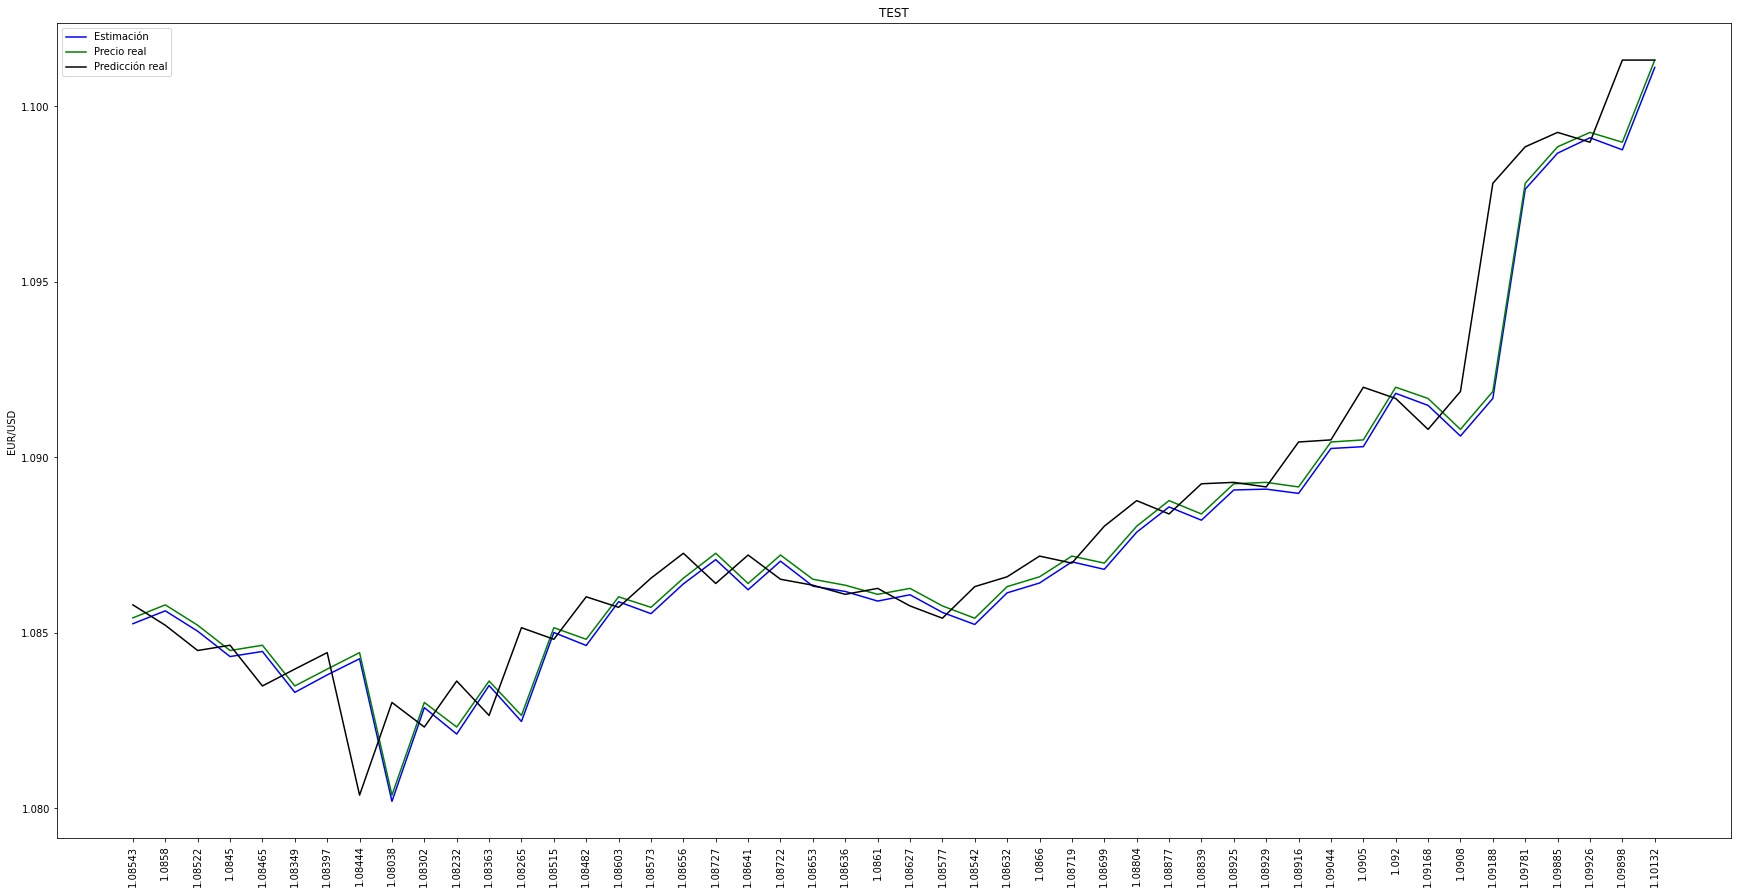

In [29]:
plt.plot(yhat_test.flatten()[-48:], color='blue', label='Estimación')
plt.plot(data1['precio_EURUSD'].values[-48:], color='green', label='Precio real')
plt.plot(y_test[-48:], color='black', label='Predicción real')
plt.legend()
plt.ylabel('EUR/USD')
plt.xticks(range(48),data1['precio_EURUSD'].astype(str).values[-48:],rotation=90)
#plt.xticks(range(48),[x[1] if x[0]%10==0 else '' for x in enumerate(Yte['fecha'].astype(str).values[-48:])],rotation=90)
plt.title('TEST')
plt.rc('figure', figsize=(30, 15))

plt.show()

## SAVE (notebook)



In [ ]:
%%javascript
IPython.notebook.save_notebook()